In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.table import Table
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from astropy import wcs
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
#import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual
import sep
from photutils import CircularAperture

%config InlineBackend.figure_format = 'retina'

In [2]:
#lnl_cube = fits.open("FCC255_data/FCC255_lnl_cube-005.fits")
#Gandalf_fit = fits.open("FCC255_data/FCC255_GandALF_fit-003.fits")
#Gandalf_fit_emission = fits.open("FCC255_data/FCC255_GandALF_fit_emission-002.fits")
#ppxf_fit = fits.open("FCC255_data/FCC255_pPXF_fit-004.fits")

In [36]:
Gandalf_stellar = Gandalf_fit[0].data - Gandalf_fit_emission[0].data
emission_cube = lnl_cube[0].data - Gandalf_stellar

In [40]:
hdu = fits.PrimaryHDU(emission_cube)
hdu.writeto("FCC255_data/FCC255_emission_cube.fits")

In [2]:
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC255_data/FCC255_emission_cube.fits")
raw_data = hdulist[0].data
hdr = hdulist[0].header

full_wavelength = np.load("exported_data/FCC255/wavelength.npy")
# wavelength[382] = 4940.58678
# wavelength[542] = 5090.374537
wavelength = full_wavelength[382:543]


y_data = 449 # hdr["NAXIS2"]
x_data = 442 # hdr["NAXIS1"]

coordinates = [(n,m) for n in range(x_data) for m in range(y_data)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

oo = np.loadtxt('FCC255_data/FCC255_xy_ima_yngoodspaxels.txt', skiprows=1)
fit_these = oo[:,3]

raw_data_list = raw_data[:,382:543]

raw_data_list_fitted = np.squeeze(np.where(fit_these == 1))

raw_data_list_for_fit = raw_data_list[raw_data_list_fitted]

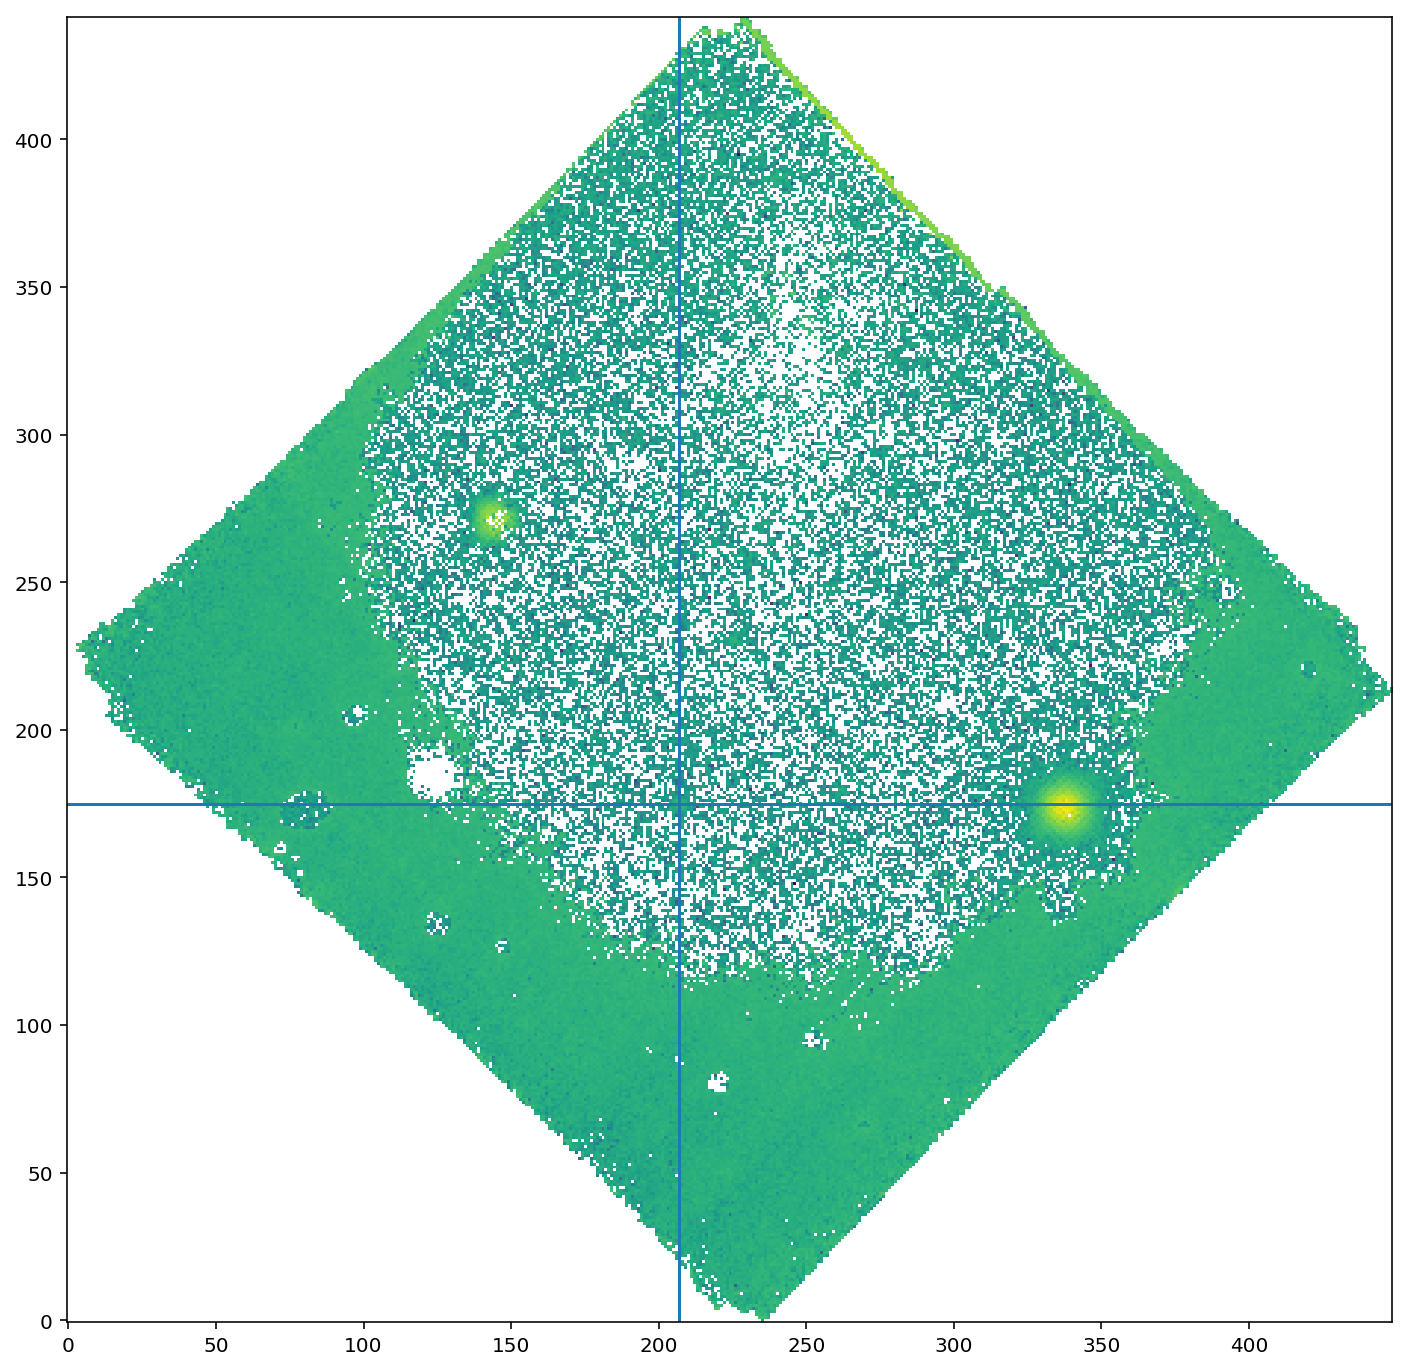

In [42]:
import matplotlib.colors as colors
plt.figure(figsize=(12,12))
plt.imshow(np.sum(raw_data_list.reshape(y_data, x_data, len(wavelength)),2), origin="lower", norm=colors.LogNorm())
plt.axhline(175)
plt.axvline(207)

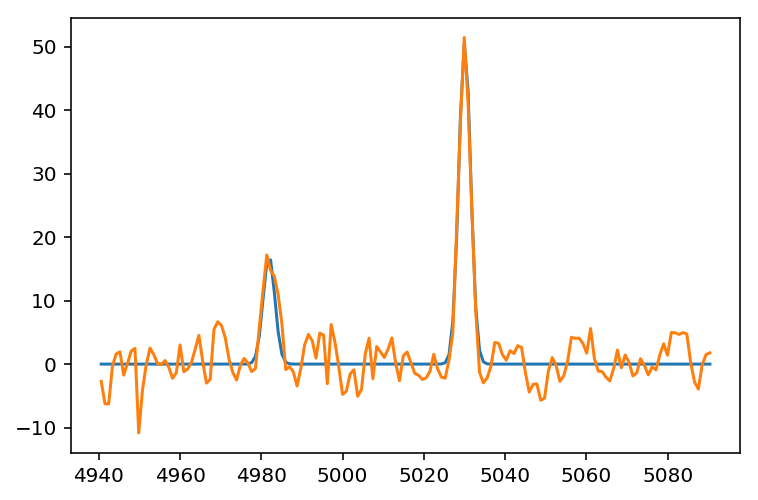

In [48]:
G_F_E = Gandalf_fit_emission[0].data
G_F_E_cube = G_F_E.reshape(y_data, x_data, len(full_wavelength))
plt.plot(wavelength, G_F_E_cube[175][206][382:543])

data_cube = raw_data_list.reshape(y_data, x_data, len(wavelength))
plt.plot(wavelength, data_cube[175][206])

# 1D fit function

In [16]:
def Gaussian_1D_res(params, x, data, error, spec_num):
    Amp = params["Amp"]
    mean = params["mean"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]
     
    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.))
    
    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model
    
    return (data - model) / error


params = Parameters()
params.add("Amp",value=50., min=0.001, max=500.)
params.add("mean", value=5040., min=5000., max=5080.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001)#, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

list_of_rN = np.zeros(len(raw_data_list))
list_of_residuals = np.zeros((len(raw_data_list),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(raw_data_list),len(wavelength)))
best_fit_A = np.zeros((len(raw_data_list),2))
best_fit_mean = np.zeros((len(raw_data_list),2))


In [ ]:
for spec_n in raw_data_list_fitted:
    results = minimize(Gaussian_1D_res, params, args=(wavelength, raw_data_list[spec_n], input_errors[spec_n], spec_n), nan_policy="propagate")
    best_fit_A[spec_n] = [results.params["Amp"], results.params["Amp"].stderr]
    best_fit_mean[spec_n] = [results.params["mean"], results.params["mean"].stderr]
    list_of_residuals_from_fitter[spec_n] = results.residual

In [11]:
gauss_A = [A[0] for A in best_fit_A]
A_err = [A[1] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
A_rN_shape = A_rN.reshape(x_data,y_data)

Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

In [12]:
np.save("exported_data/FCC255/A_rN_cen", A_rN)
np.save("exported_data/FCC255/gauss_A_cen", gauss_A)
np.save("exported_data/FCC255/gauss_A_err_cen", A_err)
np.save("exported_data/FCC255/gauss_F_cen", Gauss_F)
np.save("exported_data/FCC255/list_of_resids_min", list_of_residuals)
np.save("exported_data/FCC255/list_of_resids_min_obj", list_of_residuals_from_fitter)
np.save("exported_data/FCC255/rN", list_of_rN)

In [9]:
A_rN = np.load("exported_data/FCC255/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC255/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC255/gauss_F_cen.npy")

gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

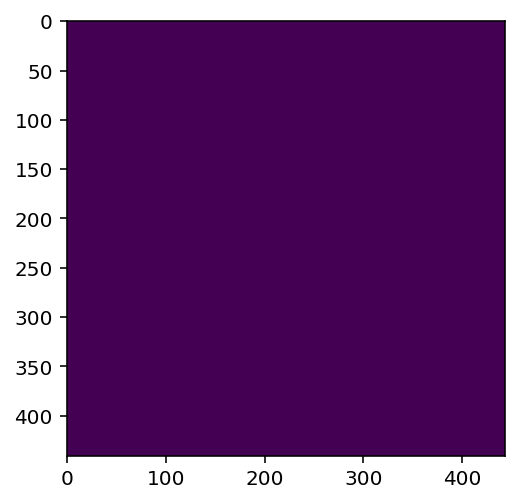

In [12]:
rN_shape = rN.reshape(y_data, x_data)

plt.imshow(rN_shape)

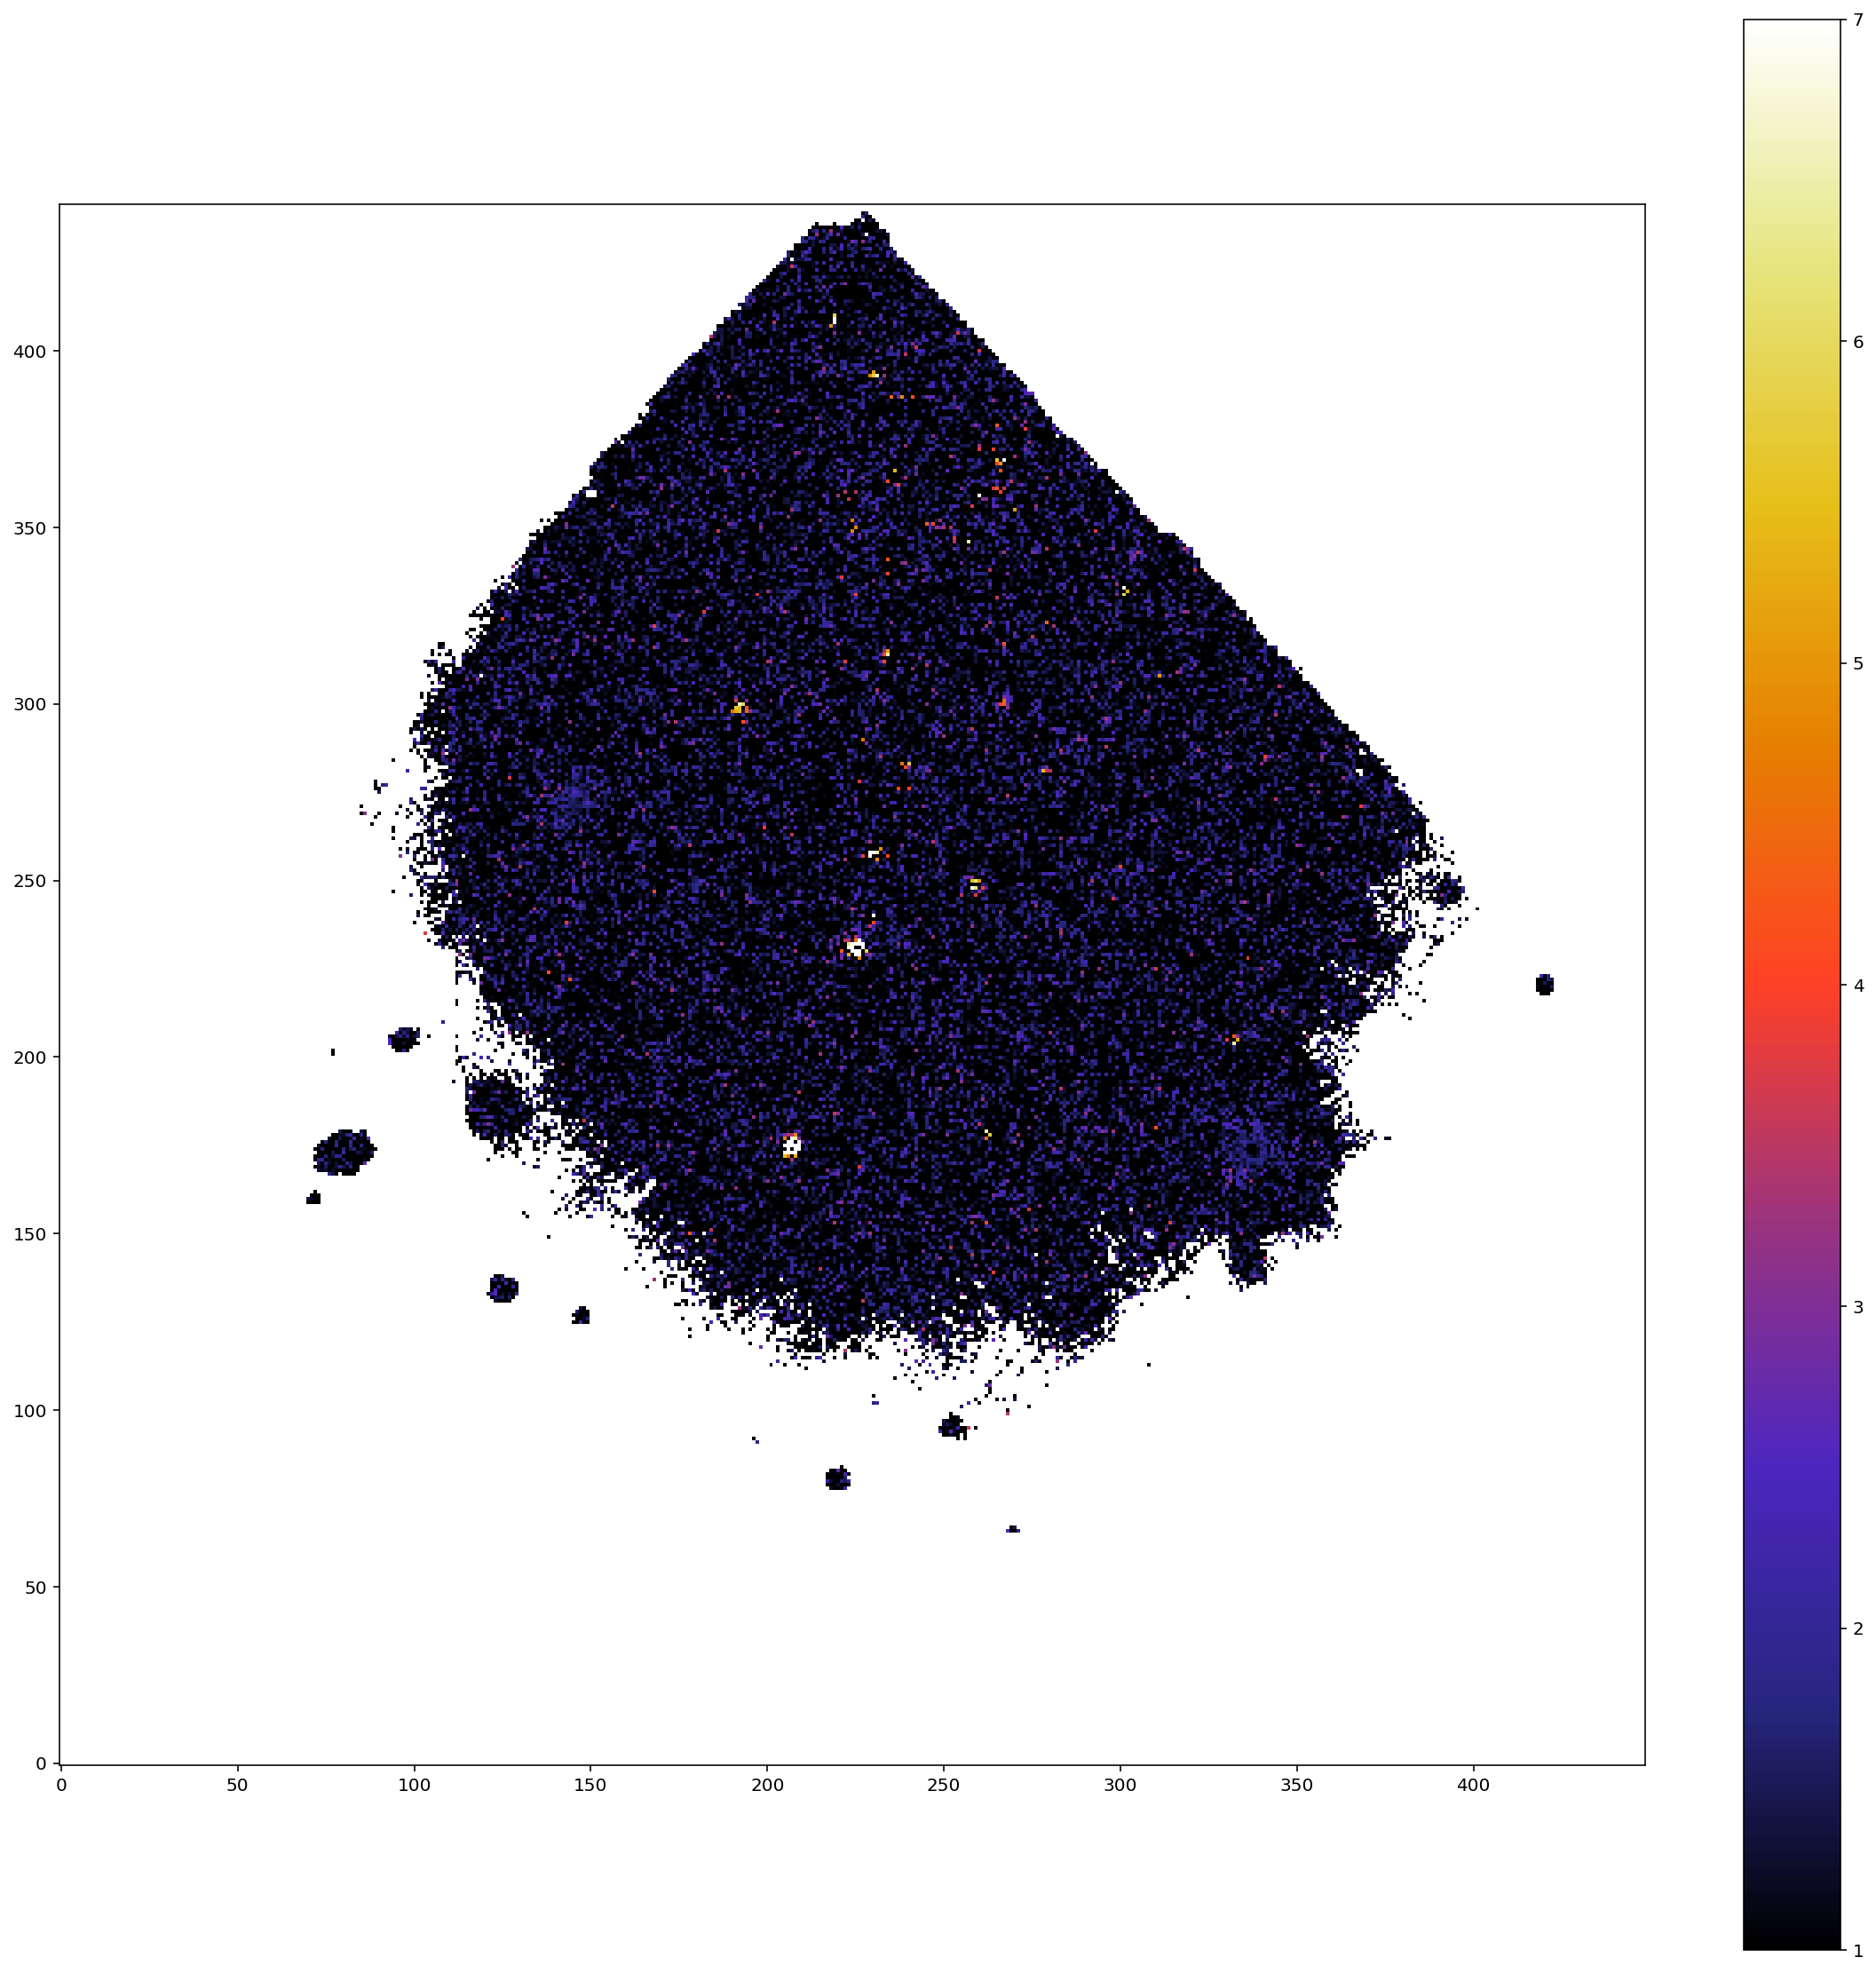

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=7)
plt.colorbar()


In [17]:
best_fit_A[1559]

array([44.27270458, 11.15721631])

In [14]:
temp_g_A = gauss_A_shape
temp_g_A[gauss_A_shape==gauss_A_shape[0,0]] = np.nan

In [4]:
temp_A_rN = A_rN_shape
temp_A_rN[A_rN_shape==A_rN_shape[0,0]] = np.nan

76


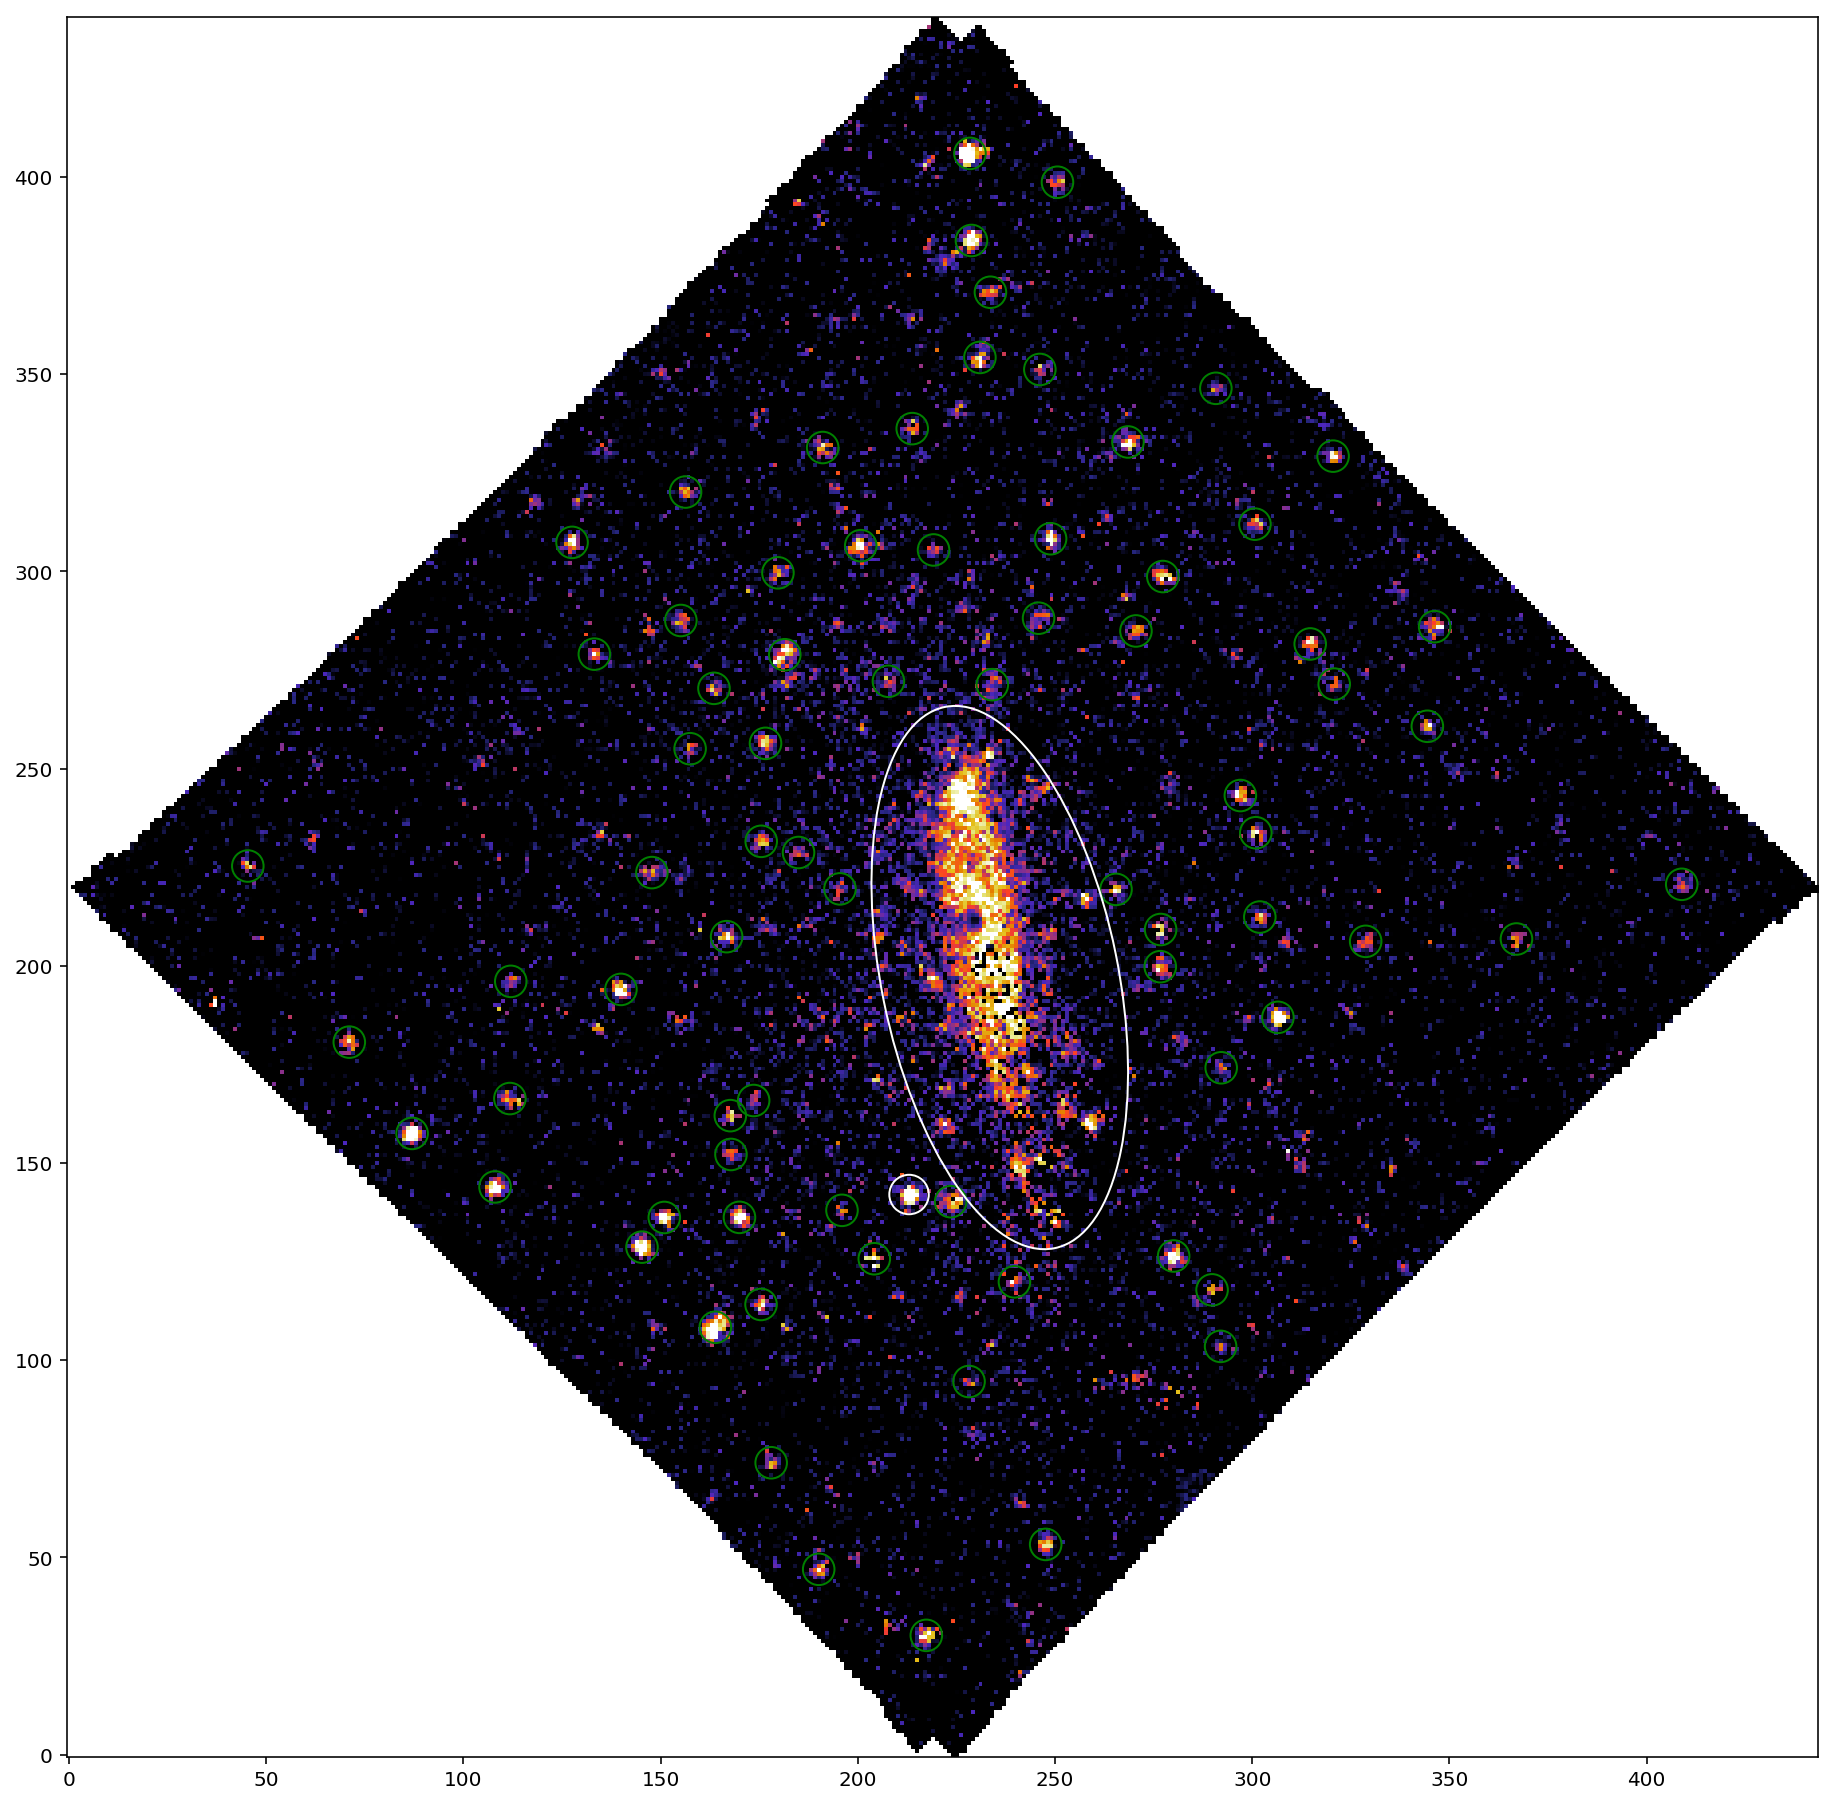

In [11]:
import sep
from photutils import CircularAperture

Y, X = np.mgrid[:y_data, :x_data]
xe = 236
ye = 197
length= 140
width = 60

alpha = 0.2
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
PNe_17_mask = (X-213)**2 + (Y-142)**2 <=4**2
galaxy_elip_mask = np.load("exported_data/FCC167/mask.npy")
#objects = sep.extract(gauss_A.reshape(441, 444), 7., err=list_of_std.reshape(y_data, x_data), clean=False, mask=elip_mask)
objects = sep.extract(temp_A_rN, 3., clean=True, mask=elip_mask_gal+PNe_17_mask)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=2, vmax=7.)
apertures.plot(color="green")

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
PNe_17 = Circle((213,142), fill=False, color="white")
#elip_extra = Ellipse((210,230), 20, 50, angle=alpha*(180/np.pi), fill=False, color="white")

ax.add_artist(elip_gal)
ax.add_artist(PNe_17)

#ax.add_artist(circ)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]

print(len(x_sep))
np.save("exported_data/FCC255/sep_x_y_list", sep_x_y_list)

In [7]:
sep_x_y_list[17]

[213.2349348499924, 141.79987220380266]

In [25]:
temp_A_rN = A_rN_shape
temp_A_rN[temp_A_rN==True]=np.nan

In [26]:

mask = A_rN_shape == A_rN_shape[0,0]

X, Y = np.mgrid[:y_data, :x_data]

#alpha = 0.17
#elip_mask = (((Y-234) * np.cos(alpha) + (X-205) * np.sin(alpha)) / 22.5) ** 2 + (((Y-234) * np.sin(alpha) - (X-205) * np.cos(alpha)) / 60) ** 2 <= 1
mask = mask +  elip_mask

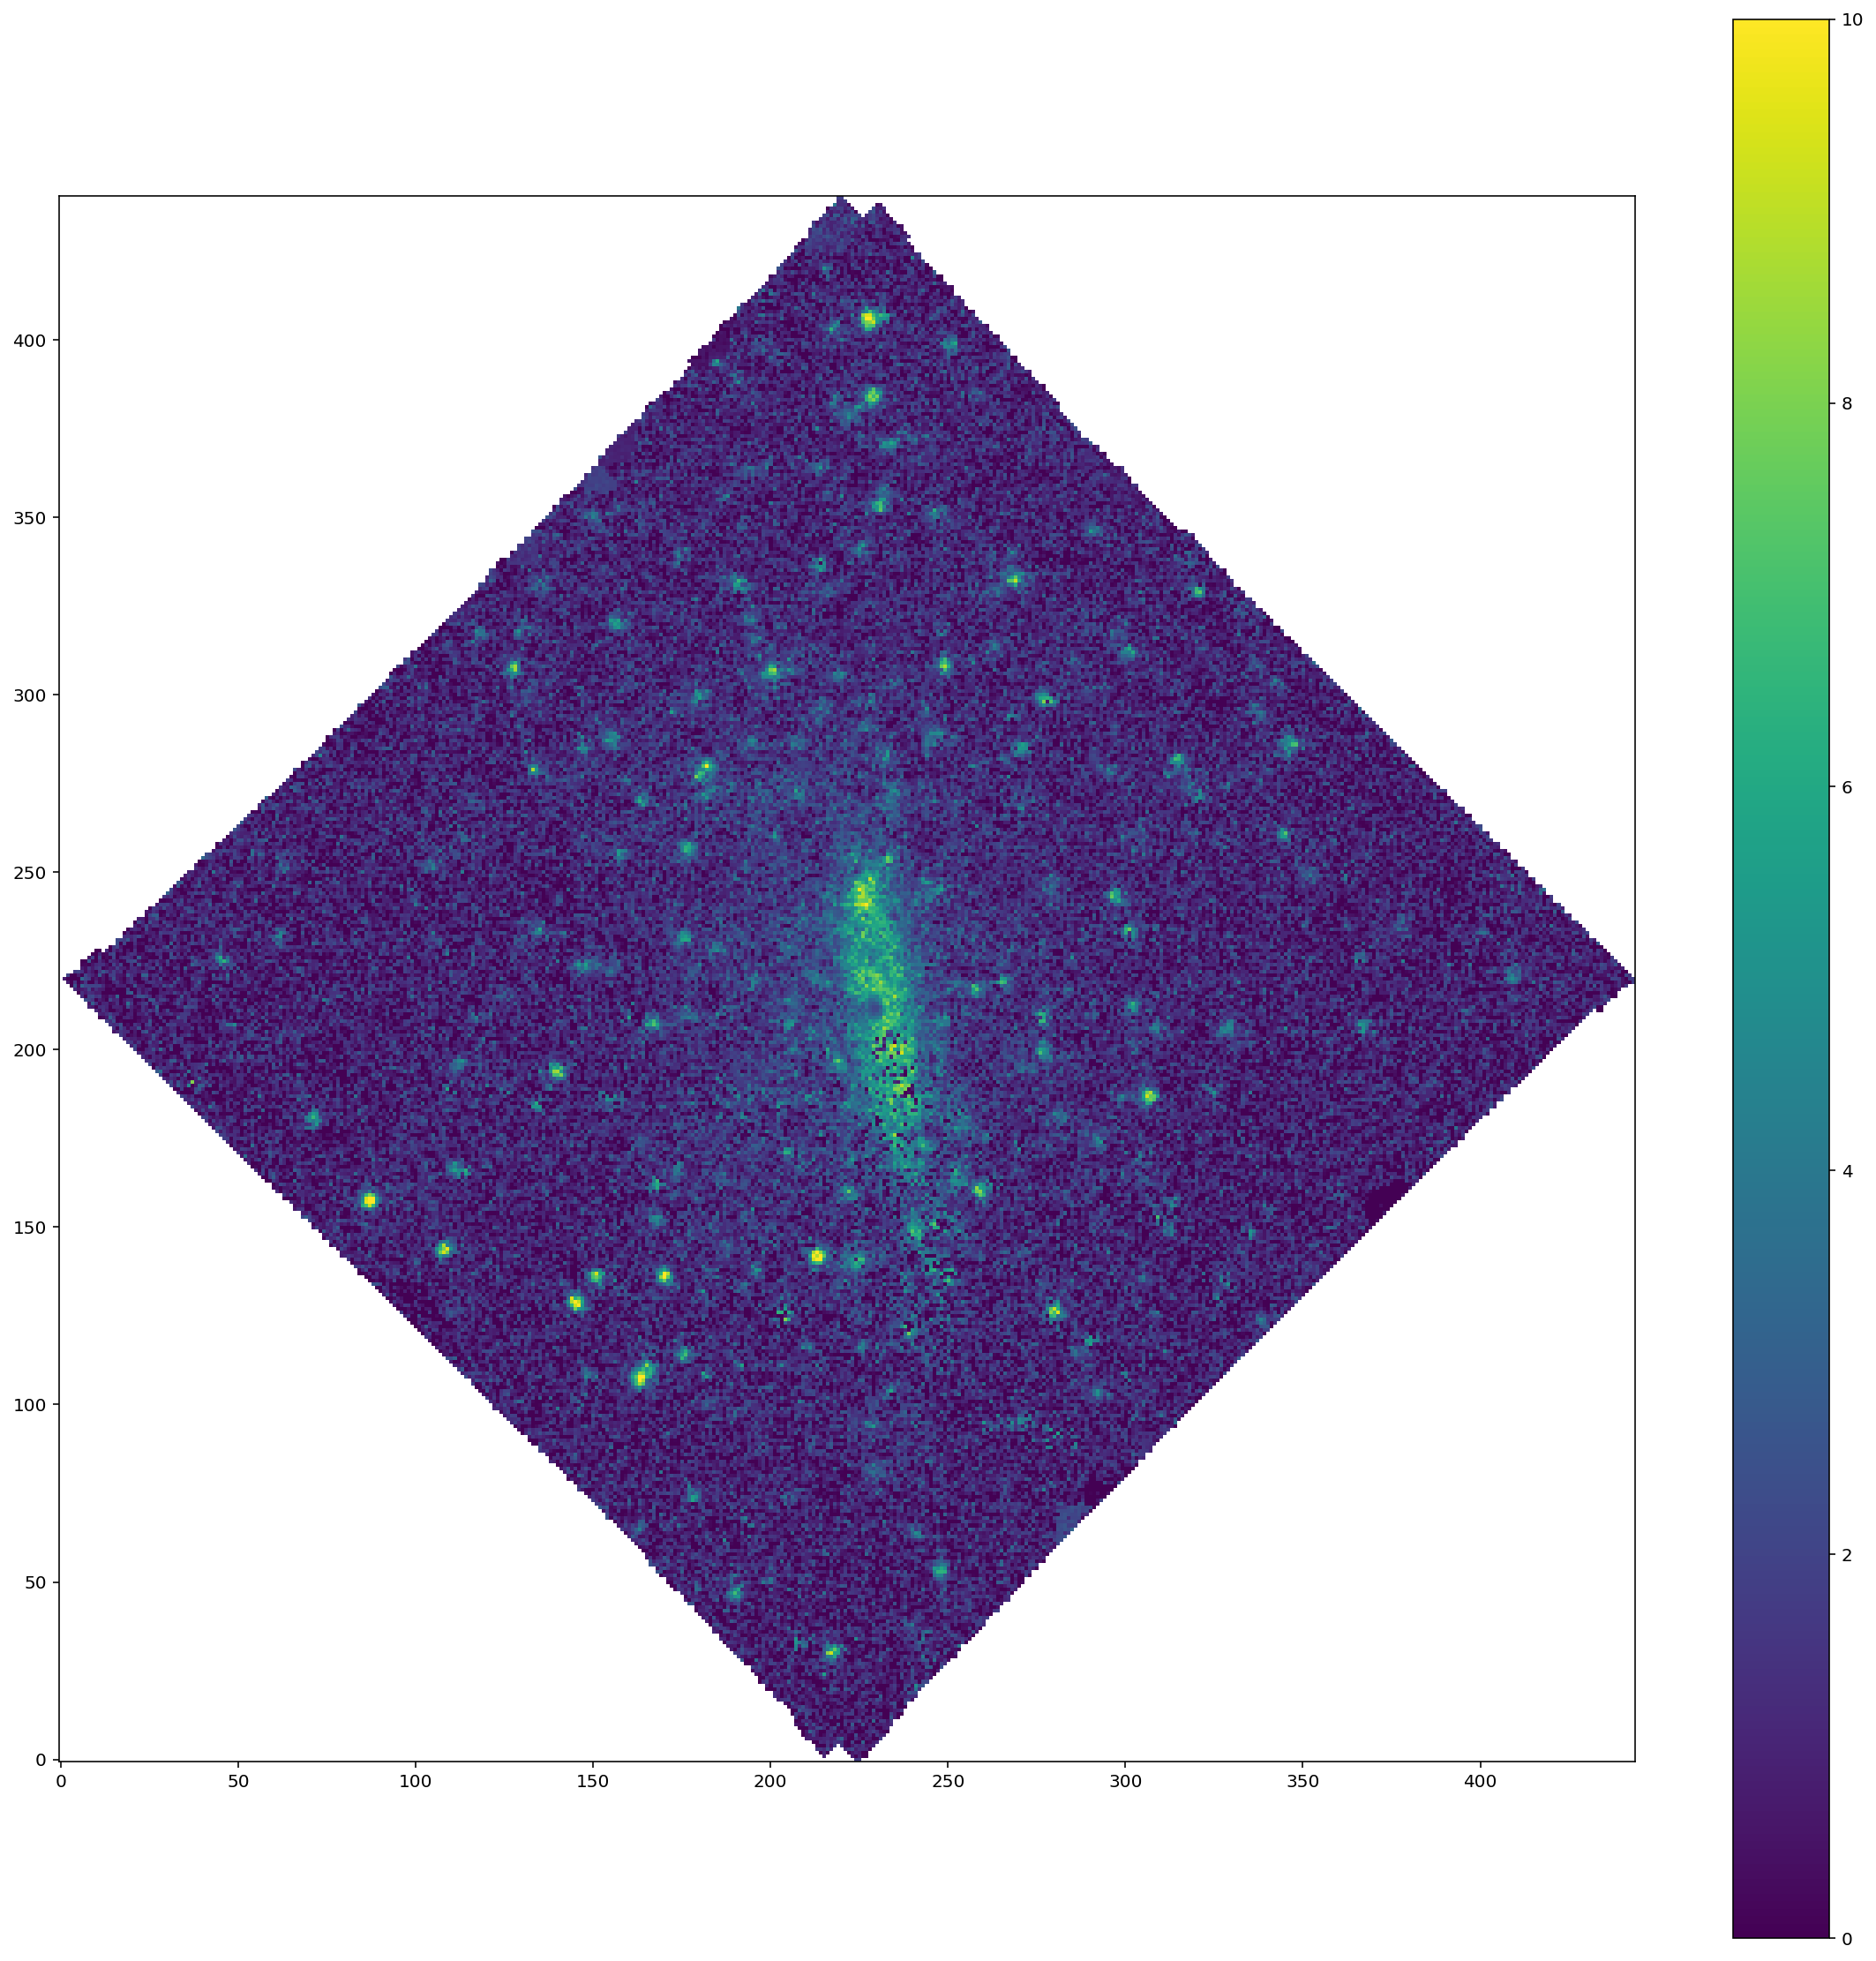

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(temp_A_rN, origin="lower", vmin=0., vmax=10.)
plt.colorbar()

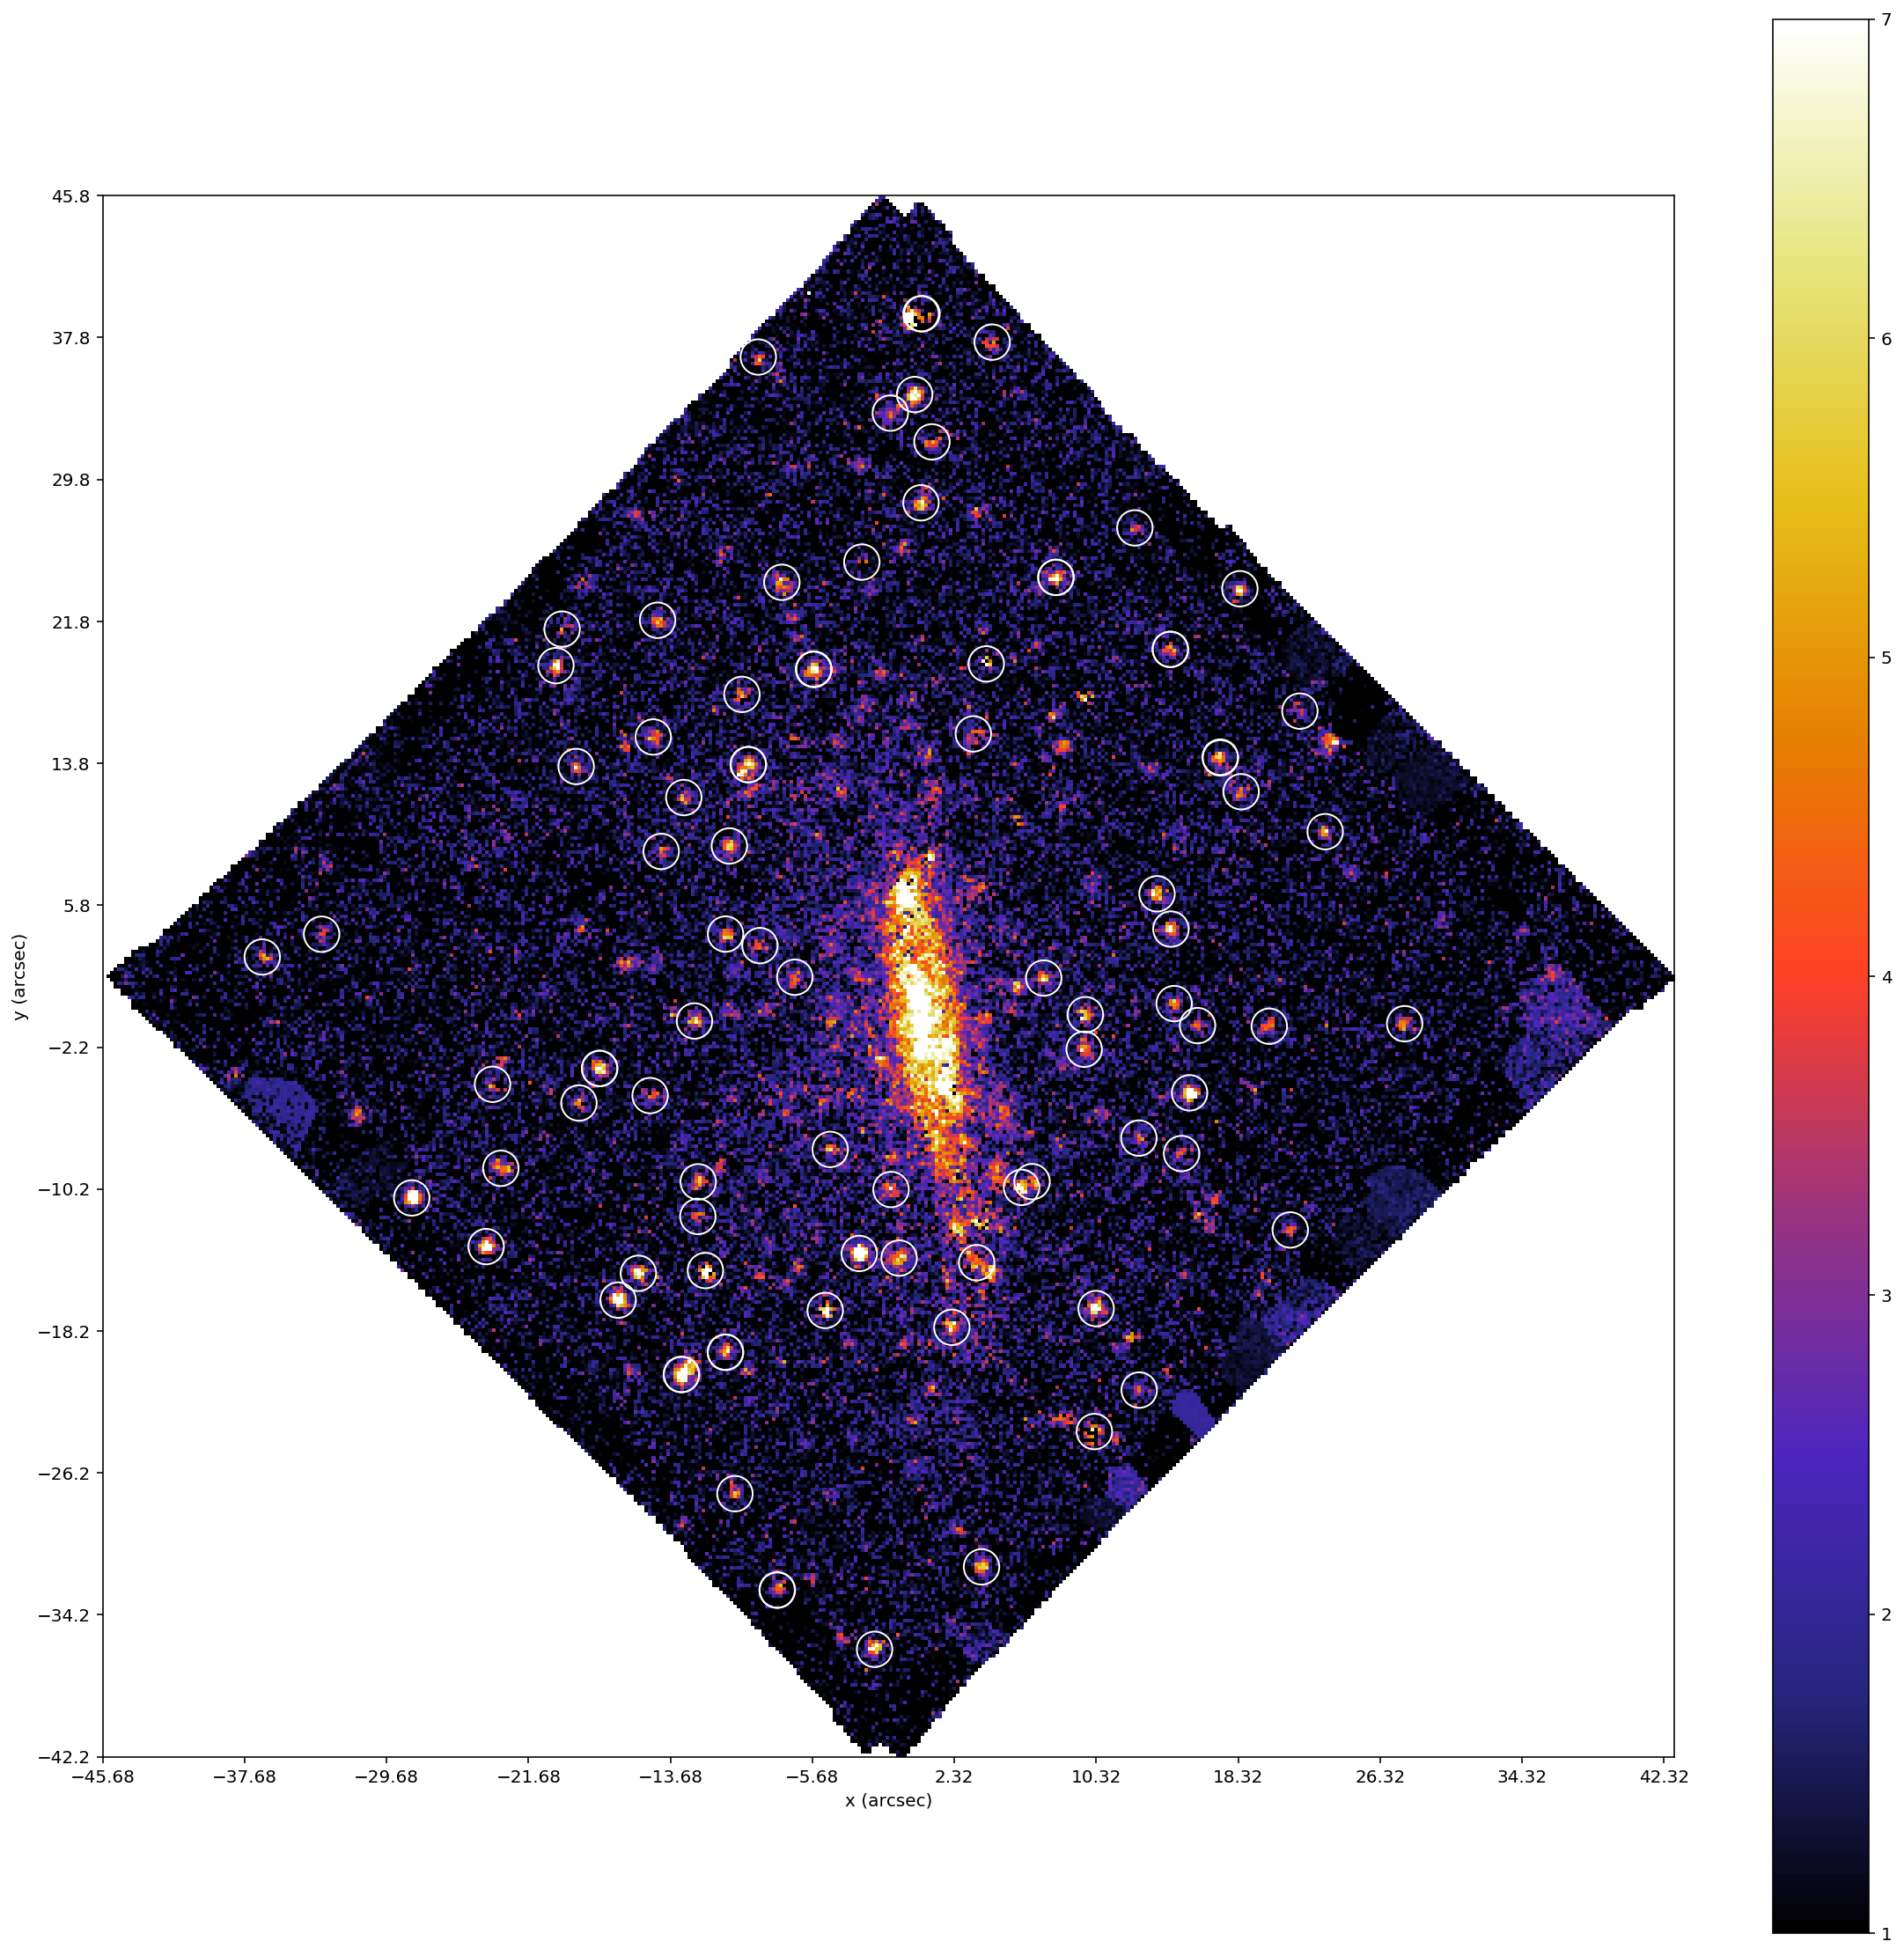

In [9]:
coords = ascii.read("FCC167_data/FCC167_xy_PNe_Marc_forThomas.txt", names=["x_PNe", "y_PNe"])
x_PNe = coords["x_PNe"]
y_PNe = coords["y_PNe"]
x_y_list = [x_PNe, y_PNe]

coords_arc = ascii.read("FCC167_data/FCC167_xy_forThomas.txt", names=["x","y"])
x_arc = coords_arc["x"][:444]
y_arc = coords_arc["y"][::444]

plt.figure(3,figsize=(20,20))
plt.imshow(A_rN_shape, extent = (x_arc[0], x_arc[-1], y_arc[0],y_arc[-1]), origin="lower", cmap="CMRmap", vmin=1, vmax=7)
plt.xticks(x_arc[::40])
plt.yticks(y_arc[::40])
cb = plt.colorbar()
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

for x, y in zip(x_PNe,y_PNe):
    ax = plt.gca()
    circ = plt.Circle((x,y),1, color="white", fill=False)
    ax.add_artist(circ)
    plt.draw()
    
plt.savefig("Plots/FCC167_circled points.png")
#for i, item in enumerate(x_y_list):
#    ax = plt.gca()
#    circ = plt.Circle((item[0],item[1]),6, color="white", fill=False)
#    ax.add_artist(circ)
#    ax.annotate(i+1, (item[0]-8, item[1]-16), color="white", size=25)
#   plt.draw()